# Rompy Core Features and Components

Rompy is a comprehensive Python package designed for generating configuration files and forcing data for numerical wave and wave-climate models. It provides a structured framework for managing model runs, spatial and temporal domains, data sources, and output specifications in a consistent and reproducible manner.

This notebook demonstrates the core components of Rompy and how they work together to facilitate the preparation of model inputs and execution of wave simulations. By understanding these fundamental building blocks, you can leverage Rompy's capabilities to streamline your wave modeling workflows.


## Core Components in Rompy

Rompy is built around several key components that work together to define and execute model simulations:

### 1. ModelRun
- **Purpose**: Orchestrates the complete model simulation process by combining all components and generating a simulation workspace ready for execution
- **Key Attributes**:
  - `run_id`: Unique identifier for the model run
  - `period`: TimeRange defining the temporal domain
  - `config`: Model-specific configuration settings
  - `output_dir`: Directory for storing model outputs
- **Methods**:
  - `run()`: Executes the model simulation

### 2. Grid
- **Purpose**: Defines the spatial domain and resolution for the simulation
- **Types**:
  - `RegularGrid`: Uniform spacing in x and y directions
  - `UnstructuredGrid`: Non-uniform mesh (if supported)
- **Key Attributes**: `x0`, `y0`, `nx`, `ny`, `dx`, `dy`, and `rot` (rotation angle)
- **Features**: Includes methods for spatial operations, visualization, and boundary detection

### 3. TimeRange
- **Purpose**: Specifies the temporal domain of the simulation with support for intervals
- **Key Attributes**: `start`, `end`, and `interval`
- **Features**: Handles time slicing and interval management for forcing data extraction

### 4. Forcing
- **Purpose**: Provides input data required for the model, including various environmental variables
- **Types**:
  - `DataGrid`: For gridded data sources (e.g., `SwanDataGrid` for SWAN model inputs)
  - `BoundaryWaveStation`: For boundary condition data
  - Other model-specific data types
- **Components**:
  - Bathymetry data
  - Wind fields
  - Wave spectra
  - Boundary conditions
  - Other environmental variables

### 5. Config
- **Purpose**: Stores model-specific configuration settings and parameters
- **Types**:
  - `SwanConfig`: Configuration for SWAN model
  - Other model-specific configurations
- **Key Components**:
  - Physics parameters (wave generation, dissipation, etc.)
  - Numerical scheme settings
  - Output specifications and formats

### 6. Output
- **Purpose**: Defines what data to save from the model run and how to format it
- **Components**:
  - Variables to output
  - Output locations and frequency
  - Output format specifications

The base objects contained in the Rompy package are designed to provide a flexible scaffolding for building model-specific implementations. This modular approach allows for customization while maintaining consistency across different wave models. The following examples demonstrate how these base objects can be used to prepare and execute model runs before exploring model-specific implementations.



In [1]:
from pathlib import Path
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

workdir = Path.cwd() / "basedemo"
workdir.mkdir(exist_ok=True)


def print_new_contents(path, old_contents=None):
    """
    Helper function to display directory contents and highlight new files.

    Parameters:
    -----------
    path : Path
        Directory path to inspect
    old_contents : set, optional
        Previously existing file names for comparison

    Returns:
    --------
    set : Set of current file names in the directory
    """
    print(f"\nContents of {path}:")
    for item in path.iterdir():
        if item.is_dir():
            print(f" - {item.name}/")
            print_new_contents(item, old_contents=old_contents)
        if old_contents is None or item.name not in old_contents:
            print(f" - {item.name} (new)")
        else:
            print(f" - {item.name}")
    return set(item.name for item in path.iterdir())


# Initialize workspace contents tracking
contents = print_new_contents(workdir)


def plot_nc(
    ncfile,
    varname,
    timestep=None,
    cmap=None,
    grid=None,
):
    """Helper function to plot a variable from a NetCDF file."""
    # display(ncfile)
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ds = xr.open_dataset(ncfile)
    if timestep is not None:
        p = ds[varname].isel(time=timestep).plot(ax=ax, cmap=cmap)
    else:
        p = ds[varname].plot(ax=ax, cmap=cmap)
    ax.coastlines()
    if grid is not None:
        grid.plot(ax=ax)
    plt.title(f"{varname} from {ncfile.name}")
    return p


def plot_spectra(spectra, grid=None, markersize=6):
    """Helper function to plot wave spectra from a NetCDF file."""
    ds = xr.open_dataset(spectra)
    # display(ds)
    fig, ax = plt.subplots(
        figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()}
    )
    if grid:
        grid.plot(ax=ax)
    c = ds.isel(time=[0]).spec.hs()
    p = ax.scatter(
        ds.lon,
        ds.lat,
        s=markersize,
        c=c,
        cmap="turbo",
        vmin=0,
        vmax=4,
        transform=ccrs.PlateCarree(),
    )
    ax.set_title(c.time.to_index().to_pydatetime()[0])
    plt.colorbar(p, label=f"Hs (m)")
    ax.coastlines()
    ax.grid(True)


Contents of /home/tdurrant/source/rompy/rompy-meta/repos/rompy-notebooks/notebooks/common/basedemo:
 - gebco_bathymetry.nc (new)
 - era5_wind.nc (new)
 - ww3_boundary.nc (new)


TO demonstrate some of the core features of rompy, we will use some sample data files.
These files are stored in the `tests/data` directory of the rompy repository.
Here we will be using the following files:
- `gebco-1deg.nc`: Global bathymetry data from GEBCO
- `era5-20230101.nc`: A course sample of ERA5 atmospheric data for January 1, 2023
- `aus-20230101.nc`: Sample wave spectra data from WW3, subset around Australia

In [2]:
DATADIR = Path("../../tests/data/")
# display(sorted(DATADIR.glob("*")))

gebco = DATADIR / "gebco-1deg.nc"
era5 = DATADIR / "era5-20230101.nc"
spectra = DATADIR / "aus-20230101.nc"

for f in [gebco, era5, spectra]:
    assert f.exists(), f"Required data file {f} not found!"


2. Grid
- **Purpose**: Defines the spatial domain and resolution
- **Types**:
  - `RegularGrid`: Uniform spacing in x and y directions
  - `UnstructuredGrid`: Non-uniform mesh (if supported)
- **Key Attributes**: x0, y0, nx, ny, dx, dy

For this demonstration, we will create a RegularGrid off the west coast of Australia.

In [3]:
from rompy.core.grid import RegularGrid

grid = RegularGrid(
    x0=110.0,  # Longitude of the lower-left corner
    y0=-35.2,  # Latitude of the lower-left corner
    rot=4.0,  # Rotation angle in degrees
    dx=0.5,  # Grid spacing in the x-direction (degrees)
    dy=0.5,  # Grid spacing in the y-direction (degrees)
    nx=15,  # Number of grid points in the x-direction
    ny=25,  # Number of grid points in the y-direction
)

# Each grid now has a bbox and a plot method
print(grid.bbox())  # Get the bounding box of the grid

[np.float64(109.1629223150705), np.float64(-35.2), np.float64(116.98294835181876), np.float64(-22.740936080673237)]


(<Figure size 633.54x1000 with 1 Axes>, <GeoAxes: >)

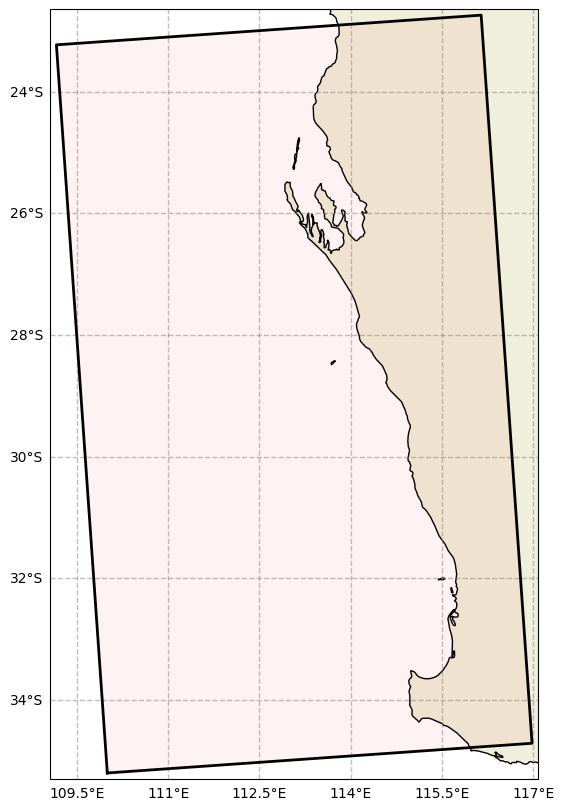

In [4]:
grid.plot()

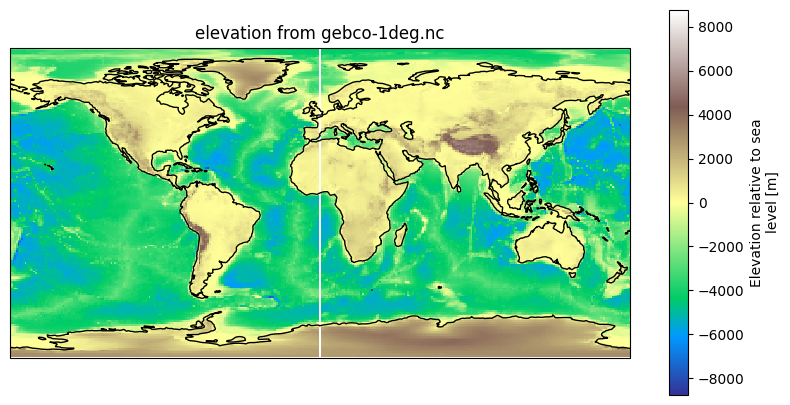

In [5]:
plot_nc(gebco, "elevation", cmap="terrain")

In [6]:
from rompy.core.data import DataGrid
from rompy.core.source import SourceFile

gebco_grid = DataGrid(
    id="gebco_bathymetry",
    source=SourceFile(uri=gebco),
    variables=["elevation"],
    coords={"y": "lat", "x": "lon"},
)
output = gebco_grid.get(grid=grid, destdir=workdir)
print_new_contents(workdir, old_contents=contents)


Contents of /home/tdurrant/source/rompy/rompy-meta/repos/rompy-notebooks/notebooks/common/basedemo:
 - gebco_bathymetry.nc
 - era5_wind.nc
 - ww3_boundary.nc


{'era5_wind.nc', 'gebco_bathymetry.nc', 'ww3_boundary.nc'}

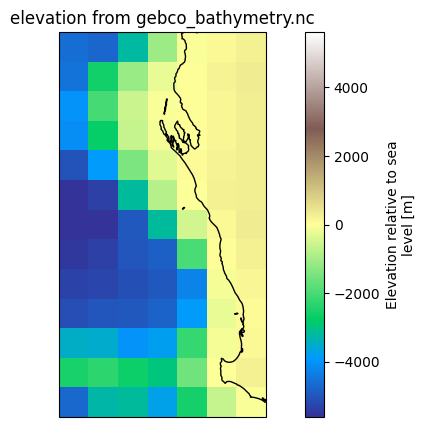

In [7]:
plot_nc(output, "elevation", cmap="terrain")

So what we have done here is:
1. Created a RegularGrid object defining our area of interest
2. Created a DataGrid object pointing to the GEBCO bathymetry file
3. Used the DataGrid's `get` method to extract the bathymetry for our grid
4. The extracted data is saved to a new NetCDF file in our working directory

For forcing data, which has a time component, we can use a TimeRange object to define the time period of interest.
Here we will create a TimeRange of 1 day with hourly intervals, and use it to extract wind data from the ERA5 file.
By passing a time and grid to the DataGrid's `get` method, we can extract the data for our grid and time range.


Lets first inspect the sample ERA5 data file

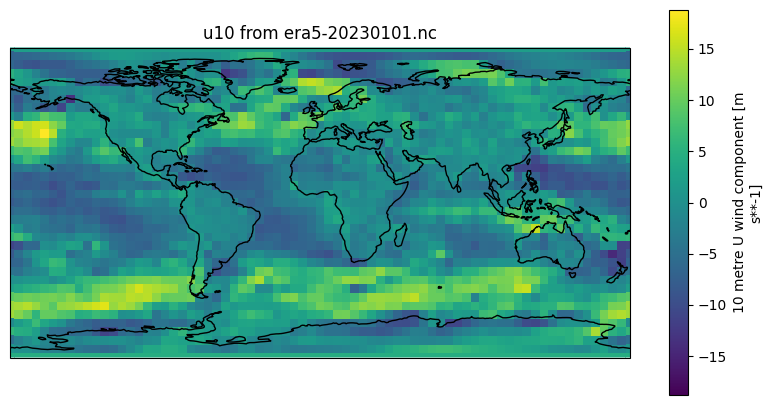

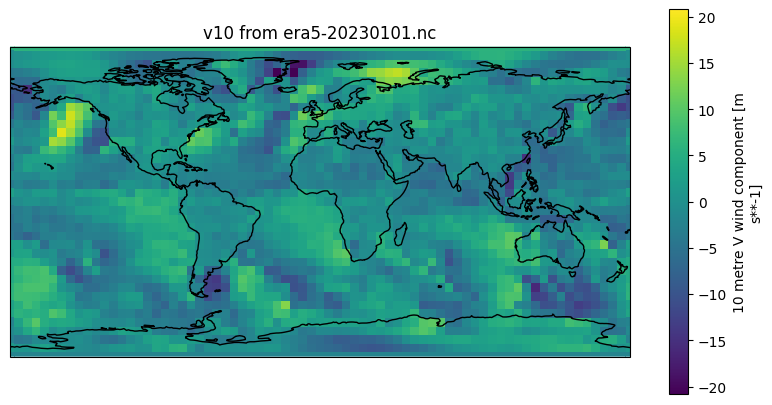

In [8]:
plot_nc(era5, "u10", cmap="viridis", timestep=0)
plot_nc(era5, "v10", cmap="viridis", timestep=0)

Now lets create a datagrid object and use the Timerange and grid to extract the wind data.
Note also that ERA5 has Latitude in reverse order, use filter to reverse it

In [9]:

from rompy.core.filters import Filter
from rompy.core.time import TimeRange

timerange = TimeRange(
    start="2023-01-01T00:00:00",
    end="2023-01-02T00:00:00",
    interval="1H",
)

era5_forcig = DataGrid(
    id="era5_wind",
    source=SourceFile(uri=era5),
    variables=["u10", "v10"],
    coords={"t": "time", "y": "latitude", "x": "longitude"},
    filter=Filter(sort=dict(coords=["latitude"])),
)
output = era5_forcig.get(grid=grid, time=timerange, destdir=workdir)
print_new_contents(workdir, old_contents=contents)


Contents of /home/tdurrant/source/rompy/rompy-meta/repos/rompy-notebooks/notebooks/common/basedemo:
 - gebco_bathymetry.nc
 - era5_wind.nc
 - ww3_boundary.nc


{'era5_wind.nc', 'gebco_bathymetry.nc', 'ww3_boundary.nc'}

Now lets have a look at the extracted wind data

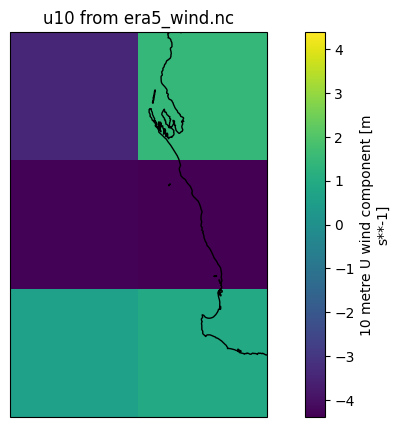

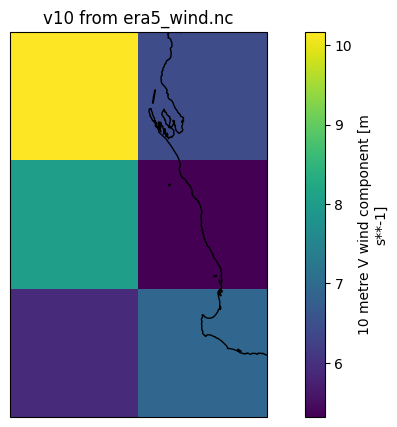

In [10]:
# Plot u10 at the first timestep
plot_nc(output, "u10", cmap="viridis", timestep=0)
# Plot v10 at the first timestep
plot_nc(output, "v10", cmap="viridis", timestep=0)

We can also extract wave spectra data in a similar way.
Here we will extract wave spectra data from the sample WW3 spectra file.
Spectra is slightly different in that we are extracting and interpolating points to
specific locations along the grid boundary, rather than simply extracting a hyperslab from
a gridded dataset. For this we use the BoundaryDataGrid object.

First, lets inspect the sample WW3 spectra data file

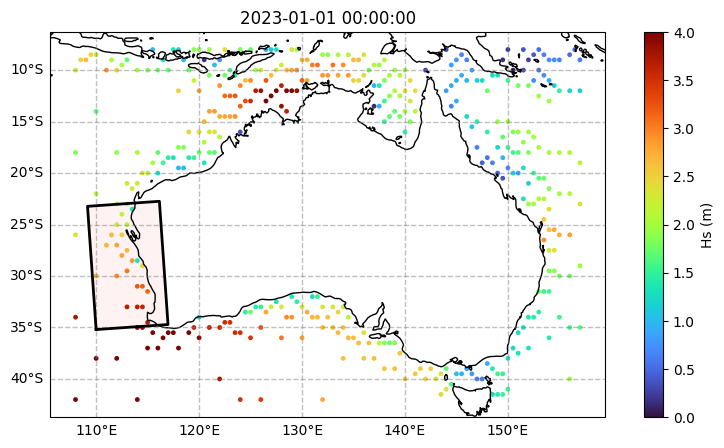

In [11]:
plot_spectra(spectra, grid=grid)

Now we can create a BoundaryWaveStation object and use it to extract the wave spectra data along the grid boundary.


Contents of /home/tdurrant/source/rompy/rompy-meta/repos/rompy-notebooks/notebooks/common/basedemo:
 - gebco_bathymetry.nc
 - era5_wind.nc
 - ww3_boundary.nc


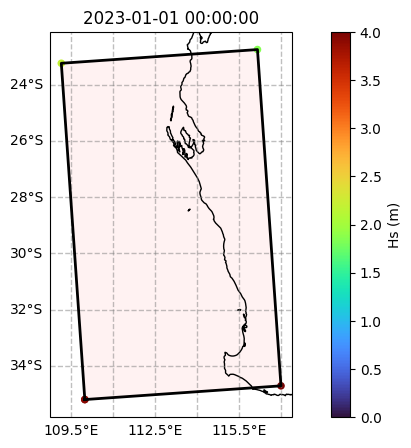

In [12]:

from rompy.core.boundary import BoundaryWaveStation

boundary_stations = BoundaryWaveStation(
    id="ww3_boundary",
    source=SourceFile(uri=spectra),
    sel_method="idw",
    sel_method_kwargs={
        "tolerance": 4
    },  # points are sparse around the offshore boundary so make sure tolerance is appropriate
)
output = boundary_stations.get(grid=grid, time=timerange, destdir=workdir)
print_new_contents(workdir, old_contents=contents)

plot_spectra(output, grid=grid, markersize=20)


plt.show()

So what we have done here is:
1. Taken an oddly spaced spectral output dataset
2. Used the BoundaryWaveStations's `get` method interpolated those spectra to the boundary using (in this case), inverse distance weighting for the period of our run
3. The extracted and interpoated data is saved to a new NetCDF file in our working directory, ready to be ingested
